# Обработка выбросов

Существует [ГОСТ Р ИСО 16269-4-2017 Статистические методы. Статистическое представление данных. Часть 4. Выявление и обработка выбросов](http://docs.cntd.ru/document/1200146680) посвященный обработке выбросов.

В соответствии с ГОСТ, **выброс (outlier)** - это элемент маломощного подмножества выборки, существенно отличающийся от остальных элементов выборки.

**Почему необходимо устранять выбросы?** Выбросы негативно влияют на построение модели.  

**Причины появления выбросов:**
- Ошибки в измерениях, например, часть значений признака "расстояние" была измерена не в километрах, а в метрах.
- Технические ошибки форматирования данных.

**Основные задачи обработки выбросов:**
- Обнаружение выбросов.
- Устранение (удаление или замена) выбросов (в зависимости от требований задачи).

## Загрузка и предобработка данных

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
import scipy.stats as stats
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from IPython.display import Image
%matplotlib inline 
sns.set(style="ticks")

In [2]:
x_col_list = ['RM', 'LSTAT', 'CRIM']

In [3]:
boston_dataset = load_boston()
data = pd.DataFrame(boston_dataset.data,
                      columns=boston_dataset.feature_names)[x_col_list]
data['Y'] = boston_dataset.target
data.shape

(506, 4)

In [4]:
def diagnostic_plots(df, variable, title):
    fig, ax = plt.subplots(figsize=(10,7))
    # гистограмма
    plt.subplot(2, 2, 1)
    df[variable].hist(bins=30)
    ## Q-Q plot
    plt.subplot(2, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    # ящик с усами
    plt.subplot(2, 2, 3)
    sns.violinplot(x=df[variable])    
    # ящик с усами
    plt.subplot(2, 2, 4)
    sns.boxplot(x=df[variable])  
    fig.suptitle(title)
    plt.show()

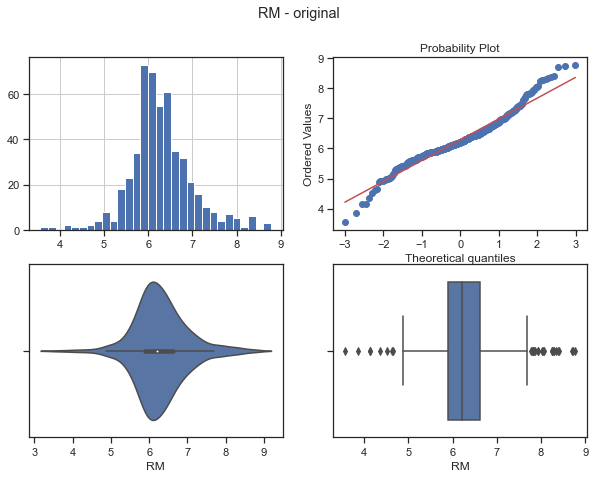

In [5]:
diagnostic_plots(data, 'RM', 'RM - original')

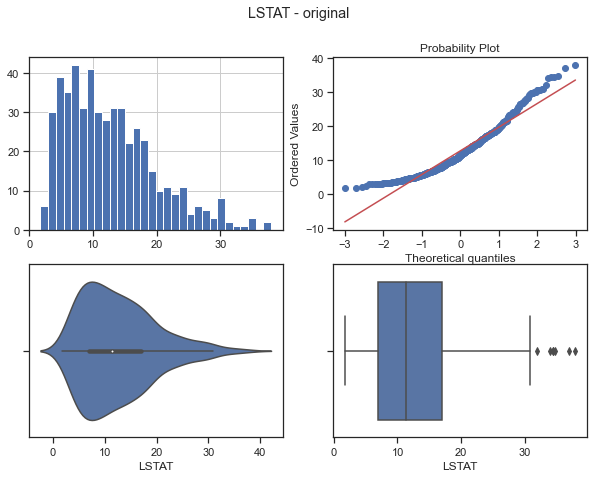

In [6]:
diagnostic_plots(data, 'LSTAT', 'LSTAT - original')

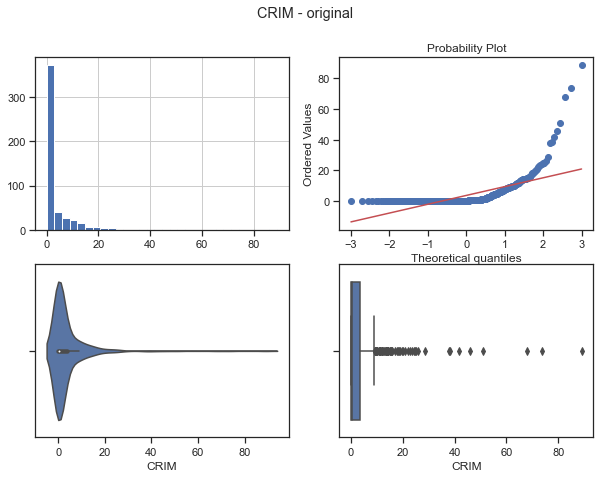

In [7]:
diagnostic_plots(data, 'CRIM', 'CRIM - original')

## Обнаружение выбросов

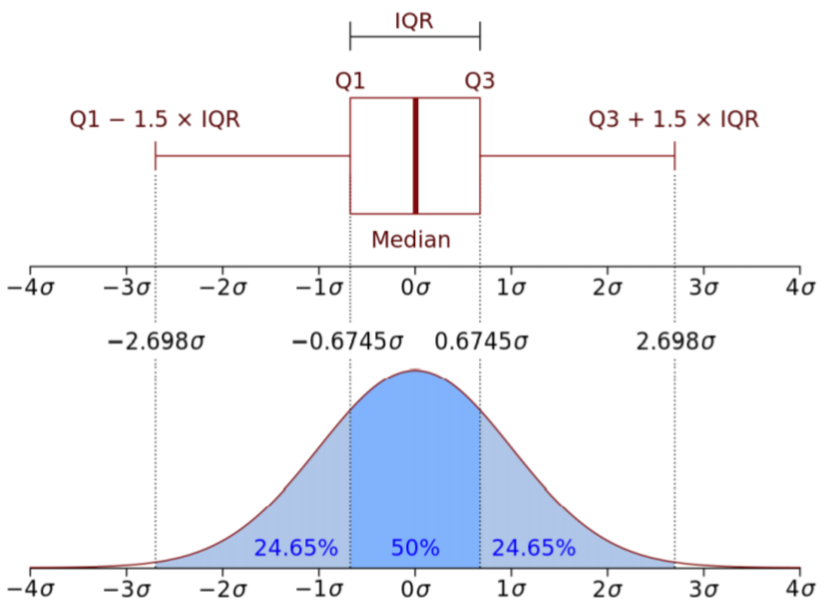

In [8]:
# Нормальное распределение
Image('img/normal_dist.png', width='50%')

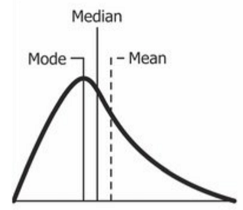

In [9]:
# Асимметричное (положительно скошенное) распределение
Image('img/center_skewed.png', width='30%')

По определению гистограммы распределения, выбросы - это значения на краях гистограммы (очень большие или очень маленькие по сравнению со всей выборкой).

Задача обнаружения выбросов - это задача выделения элементов, находящихся на краях гистограммы.

### Подход в случае нормального распределения

Или распределения, похожего на нормальное.

#### Использование правила трех сигм

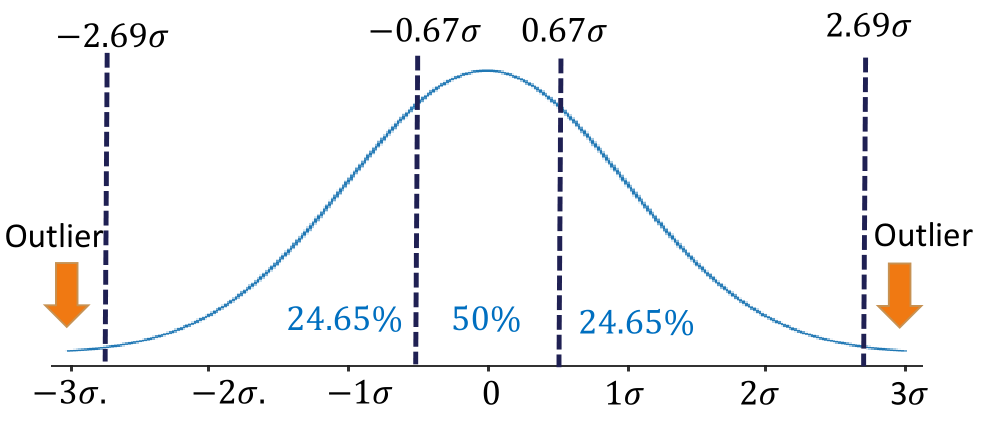

In [10]:
Image('img/out_sigma.png', width='50%')

$$ outlier < mean(x) - 3 \cdot std(x) $$
$$ outlier > mean(x) + 3 \cdot std(x) $$

где $ \sigma = std(x) $

#### Использование 5% и 95% квантилей

95% данных располагаются выше 5% квантиля и 95% данных располагаются ниже 95% квантиля. Значения ниже 5% квантиля и выше 95% квантиля можно считать выбросами.

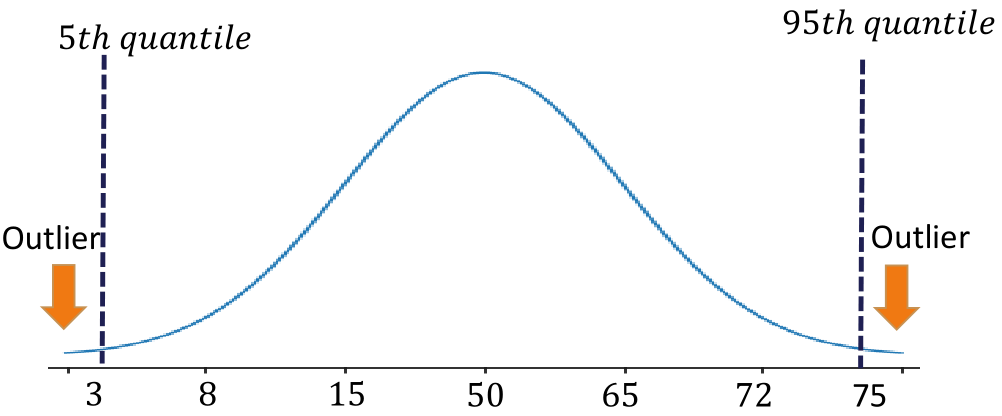

In [11]:
Image('img/out_quantile.png', width='50%')

$$ outlier < x.quantile(5\%) $$
$$ outlier > x.quantile(95\%) $$

### Подход в случае асимметричного распределения

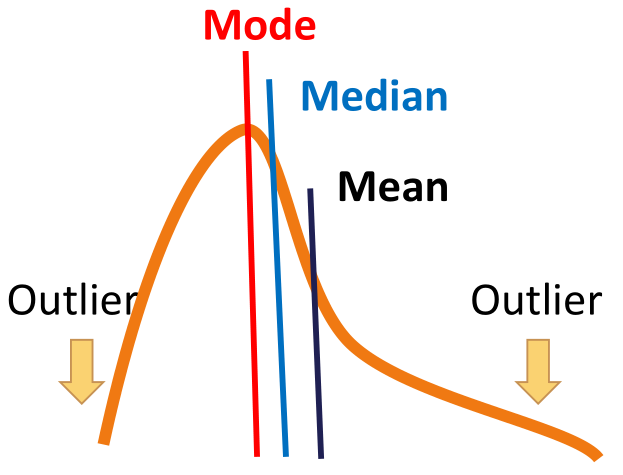

In [12]:
Image('img/out_skewed.png', width='30%')

#### Использование межквартильного размаха

Межквартильный размах IQR (interquartile range, IQR) - это разность третьего квартиля и первого квартиля:

$$ IQR = Q3(x) - Q1(x) $$

Тогда:

$$  outlier < Q1(x) - K \cdot IQR $$
$$  outlier > Q3(x) + K \cdot IQR $$

Значение $K$ обычно выбирается равным $1,5$.

In [13]:
# Тип вычисления верхней и нижней границы выбросов
from enum import Enum
class OutlierBoundaryType(Enum):
    SIGMA = 1
    QUANTILE = 2
    IRQ = 3

In [14]:
# Функция вычисления верхней и нижней границы выбросов
def get_outlier_boundaries(df, col, outlier_boundary_type: OutlierBoundaryType):
    if outlier_boundary_type == OutlierBoundaryType.SIGMA:
        K1 = 3
        lower_boundary = df[col].mean() - (K1 * df[col].std())
        upper_boundary = df[col].mean() + (K1 * df[col].std())

    elif outlier_boundary_type == OutlierBoundaryType.QUANTILE:
        lower_boundary = df[col].quantile(0.05)
        upper_boundary = df[col].quantile(0.95)

    elif outlier_boundary_type == OutlierBoundaryType.IRQ:
        K2 = 1.5
        IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
        lower_boundary = df[col].quantile(0.25) - (K2 * IQR)
        upper_boundary = df[col].quantile(0.75) + (K2 * IQR)

    else:
        raise NameError('Unknown Outlier Boundary Type')
        
    return lower_boundary, upper_boundary    

## Устранение выбросов

- Устранение предполагает удаление или замену выбросов.
- Для замены могут использоваться найденные верхняя и нижняя границы.
- Найденные выбросы можно считать "псевдо-пропущенными значениями" и использовать для их замены методы обработки пропусков.

### Удаление выбросов

In [15]:
data.shape

(506, 4)

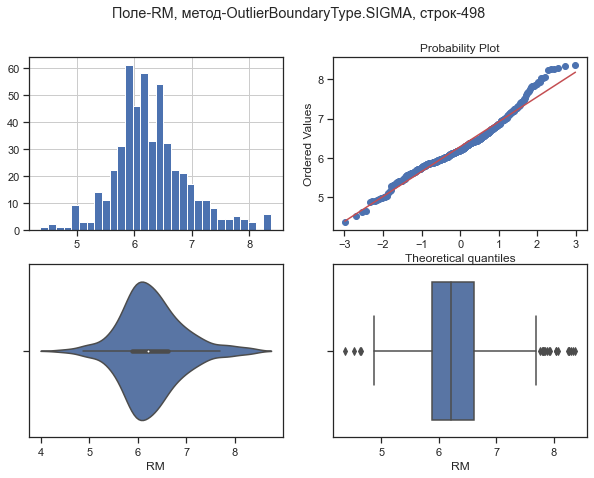

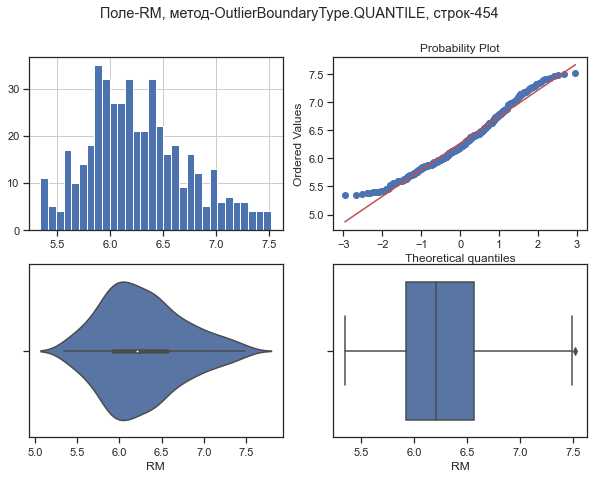

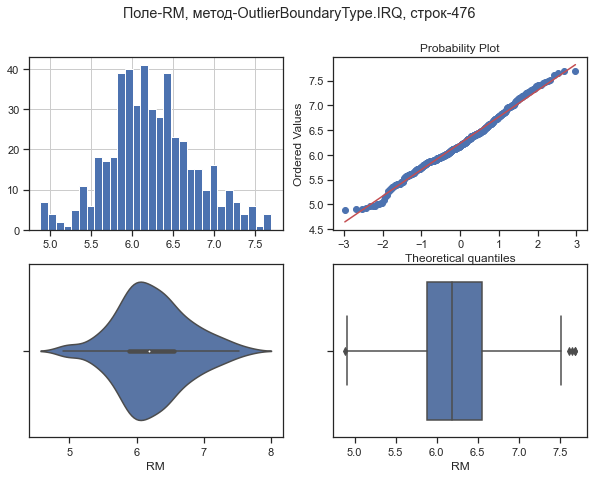

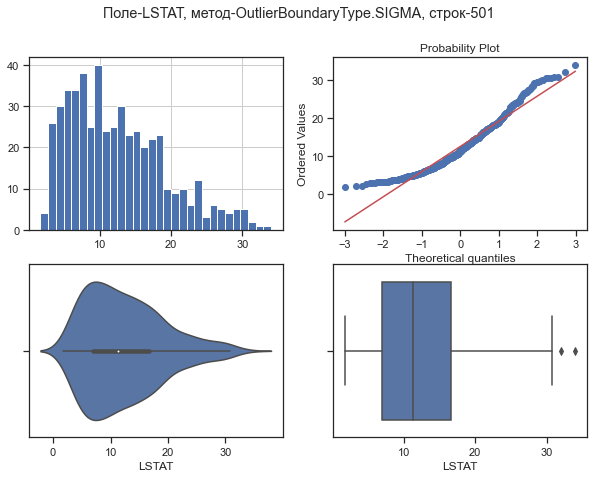

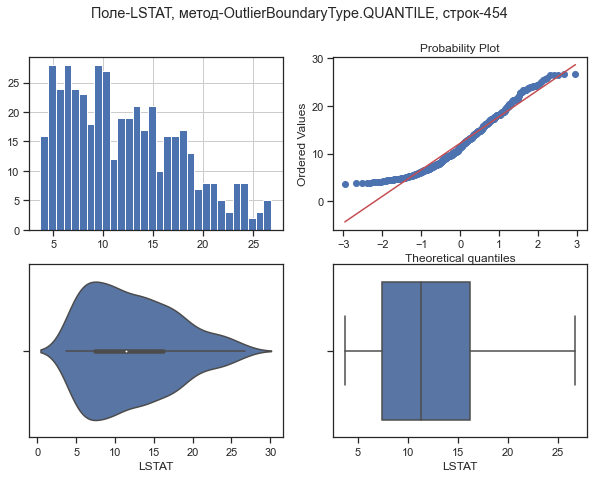

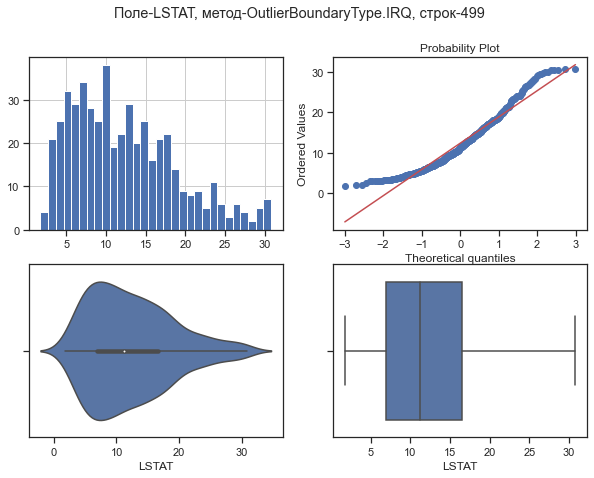

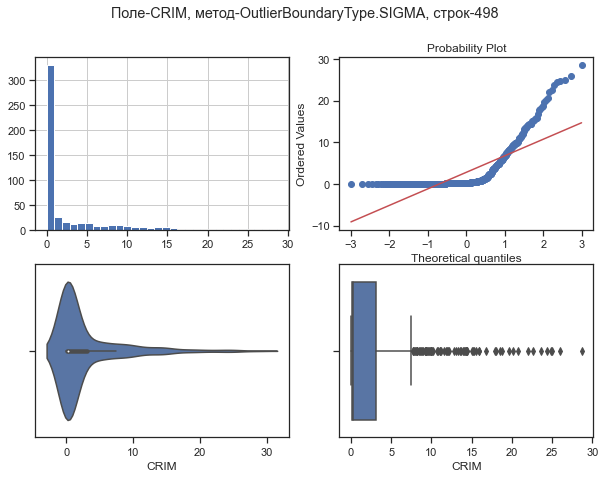

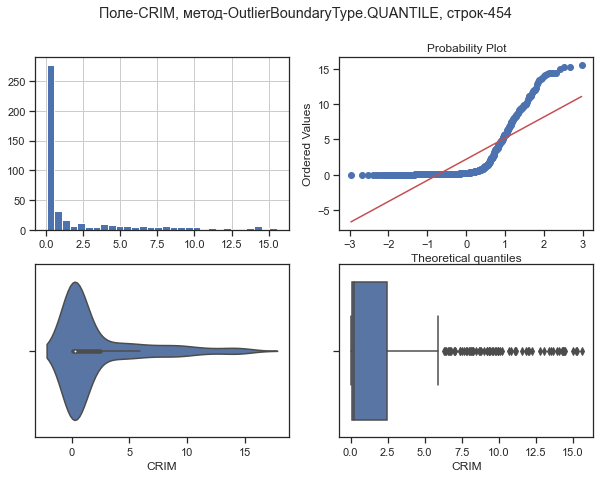

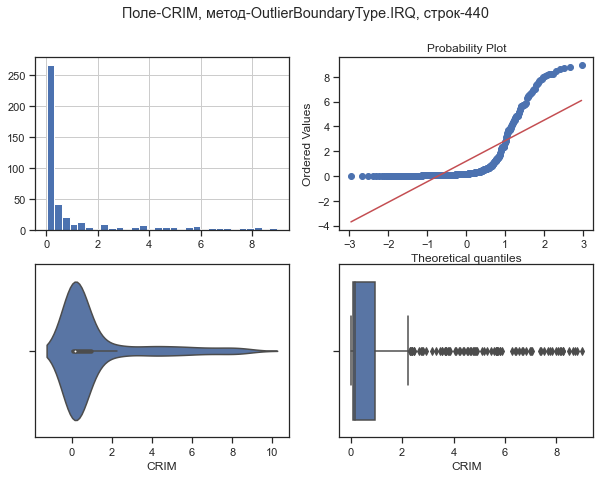

In [16]:
for col in x_col_list:    
    for obt in OutlierBoundaryType:
        # Вычисление верхней и нижней границы
        lower_boundary, upper_boundary = get_outlier_boundaries(data, col, obt)
        # Флаги для удаления выбросов
        outliers_temp = np.where(data[col] > upper_boundary, True, 
                                 np.where(data[col] < lower_boundary, True, False))
        # Удаление данных на основе флага
        data_trimmed = data.loc[~(outliers_temp), ]  
        title = 'Поле-{}, метод-{}, строк-{}'.format(col, obt, data_trimmed.shape[0])
        diagnostic_plots(data_trimmed, col, title)

### Замена выбросов

Для замены используем найденные верхнюю и нижнюю границы.

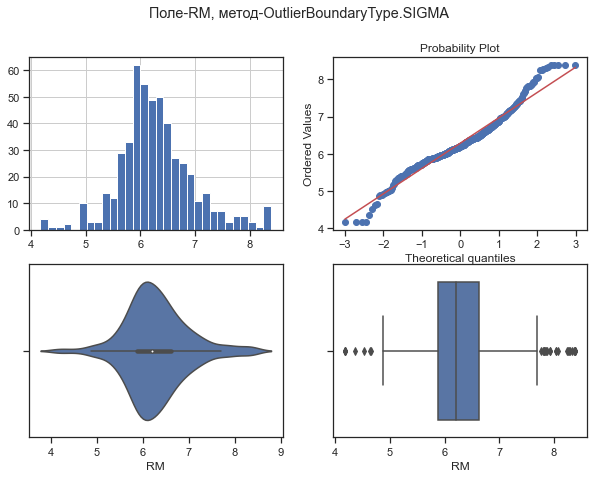

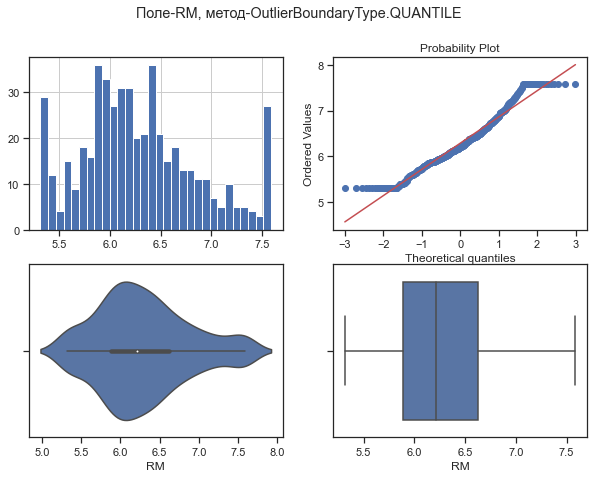

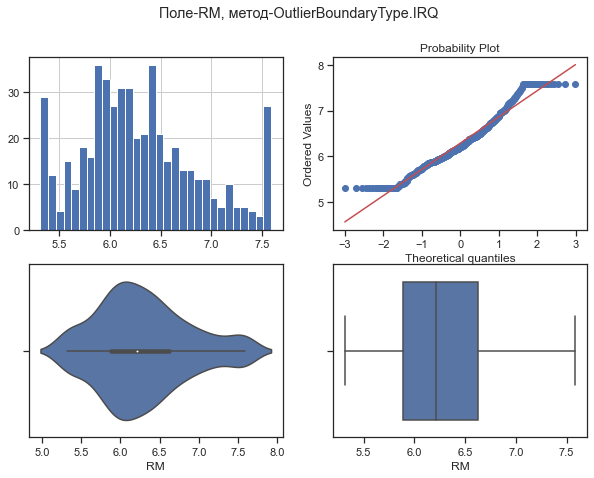

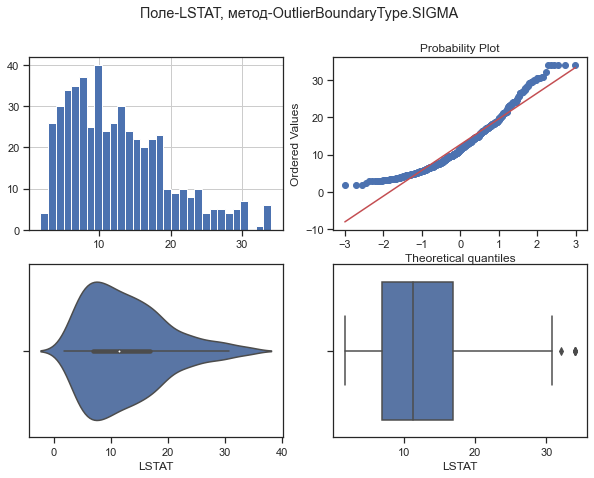

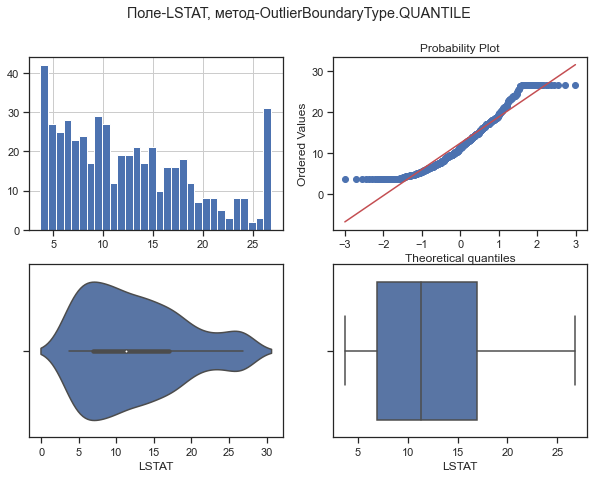

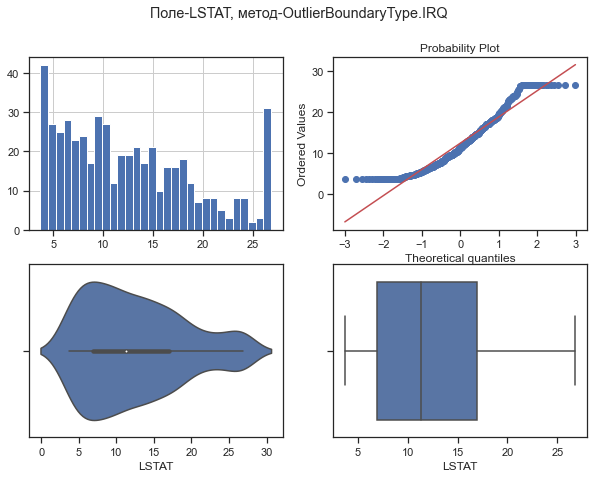

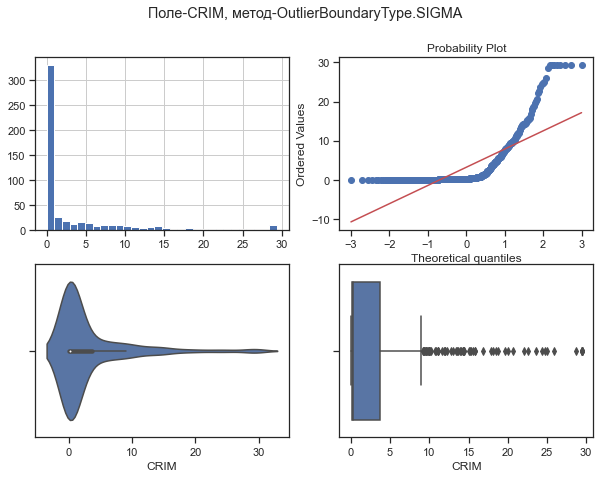

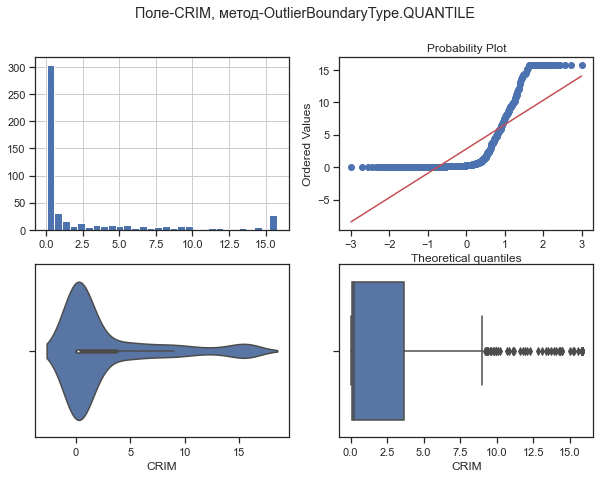

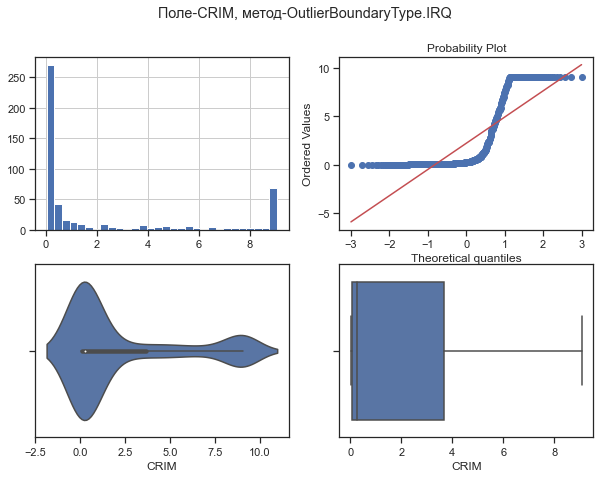

In [17]:
for col in x_col_list:    
    for obt in OutlierBoundaryType:
        # Вычисление верхней и нижней границы
        lower_boundary, upper_boundary = get_outlier_boundaries(data, col, obt)
        # Изменение данных
        data[col] = np.where(data[col] > upper_boundary, upper_boundary, 
                                 np.where(data[col] < lower_boundary, lower_boundary, data[col]))
        title = 'Поле-{}, метод-{}'.format(col, obt)
        diagnostic_plots(data, col, title)

## Обучение моделей с различными вариантами обработки выбросов

Одной из наиболее чувствительных к выбросам моделей является машина опорных векторов. 

Обработка выбросов должна производиться **ТОЛЬКО В ОБУЧАЮЩЕЙ ВЫБОРКЕ**, чтобы улучшить точность построения модели.

In [18]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.5, a-0.05, str(round(b,3)), color='white')
        plt.show()    

In [19]:
# DataFrame не содержащий целевой признак
X_ALL = data.drop('Y', axis=1)

# Разделим выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X_ALL, data['Y'],
                                                    test_size=0.2,
                                                    random_state=1)
# Преобразуем массивы в DataFrame
X_train_df = pd.DataFrame(X_train, columns=X_ALL.columns)
X_test_df = pd.DataFrame(X_test, columns=X_ALL.columns)

X_train_df.shape, X_test_df.shape

((404, 3), (102, 3))

In [20]:
# Список методов обработки выбросов
method_list = ['Original']

# Список наборов данных
x_train_list = [X_train_df]
y_train_list = [y_train]

In [21]:
# Удаление выбросов
for obt in OutlierBoundaryType:

    df1 = X_train_df.copy()
    df1['Y'] = y_train
    
    # Вычисление верхней и нижней границы
    RM_lower_boundary, RM_upper_boundary = get_outlier_boundaries(df1, 'RM', obt)
    LSTAT_lower_boundary, LSTAT_upper_boundary = get_outlier_boundaries(df1, 'LSTAT', obt)
    CRIM_lower_boundary, CRIM_upper_boundary = get_outlier_boundaries(df1, 'CRIM', obt)

    # Флаги для удаления выбросов  
    outliers_RM = np.where(df1['RM'] > RM_upper_boundary, True, 
                             np.where(df1['RM'] < RM_lower_boundary, True, False))
    outliers_LSTAT = np.where(df1['LSTAT'] > LSTAT_upper_boundary, True, 
                             np.where(df1['LSTAT'] < LSTAT_lower_boundary, True, False))
    outliers_CRIM = np.where(df1['CRIM'] > CRIM_upper_boundary, True, 
                             np.where(df1['CRIM'] < CRIM_lower_boundary, True, False))

    # Изменение данных
    data_train_trimmed = df1.loc[~(outliers_RM + outliers_LSTAT + outliers_CRIM), ]
    x_data_train_trimmed = data_train_trimmed.drop('Y', axis=1)
    y_data_train_trimmed = data_train_trimmed['Y']
    title = '{}-trimmed'.format(obt)
    # Сохранение в списки
    method_list.append(title)
    x_train_list.append(x_data_train_trimmed)
    y_train_list.append(y_data_train_trimmed)

In [22]:
# Замена выбросов
for obt in OutlierBoundaryType:
    
    df2 = X_train_df.copy()
    
    for col in x_col_list:    
        # Вычисление верхней и нижней границы
        lower_boundary, upper_boundary = get_outlier_boundaries(df2, col, obt)
        # Изменение данных
        df2[col] = np.where(df2[col] > upper_boundary, upper_boundary, 
                                 np.where(df2[col] < lower_boundary, lower_boundary, df2[col]))

    title = '{}-updated'.format(obt)
    # Сохранение в списки
    method_list.append(title)
    x_train_list.append(df2)        
    y_train_list.append(y_train)

In [23]:
clas_models_dict = {'LinR': LinearRegression(), 
                    'SVR': SVR(),
                    'KNN_5':KNeighborsRegressor(n_neighbors=5),
                    'Tree':DecisionTreeRegressor(random_state=1),
                    'GB': GradientBoostingRegressor(random_state=1),
                    'RF':RandomForestRegressor(n_estimators=50, random_state=1)}

In [24]:
def test_models(clas_models_dict, method_list, x_train_list, y_train_list, X_test, y_test):
    logger = MetricLogger()
    for model_name, model in clas_models_dict.items():
        for name, (x_data, y_data) in zip(method_list, zip(x_train_list, y_train_list)):
            model.fit(x_data, y_data)
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            logger.add(model_name, name, mse)
    return logger

In [25]:
%%time
logger = test_models(clas_models_dict, method_list, x_train_list, y_train_list, X_test, y_test)

Wall time: 1.43 s


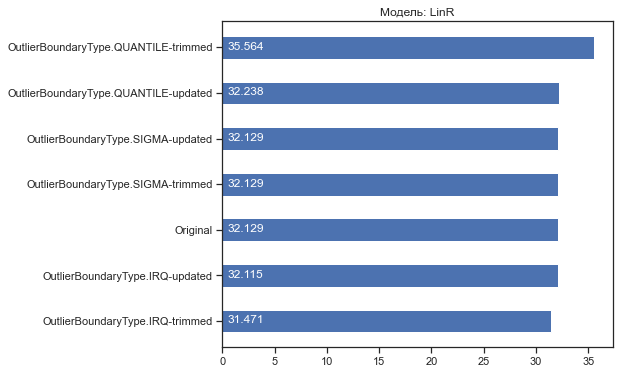

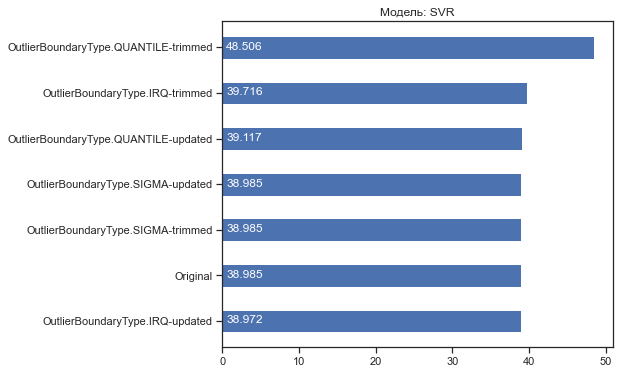

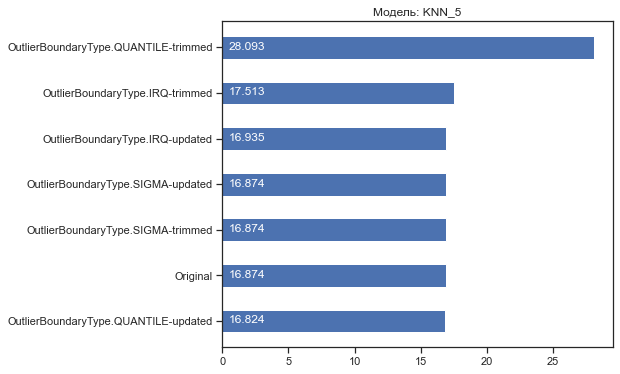

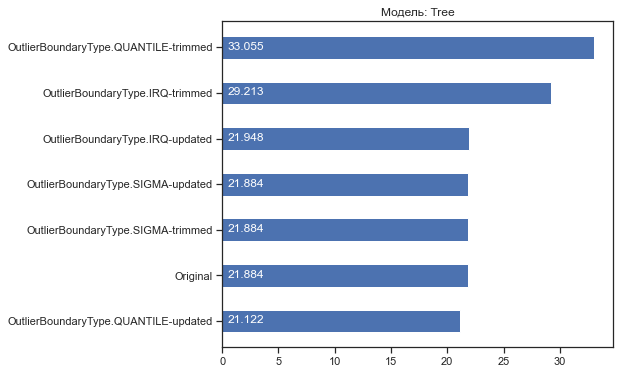

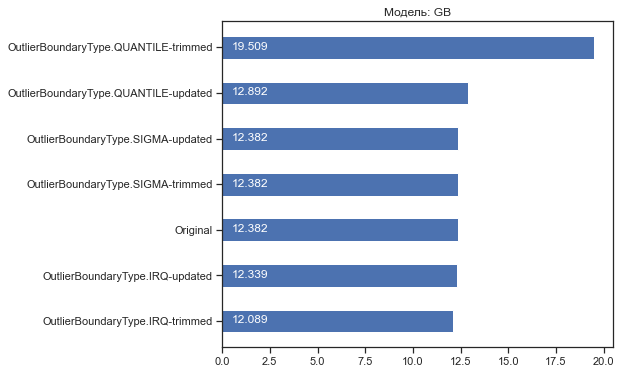

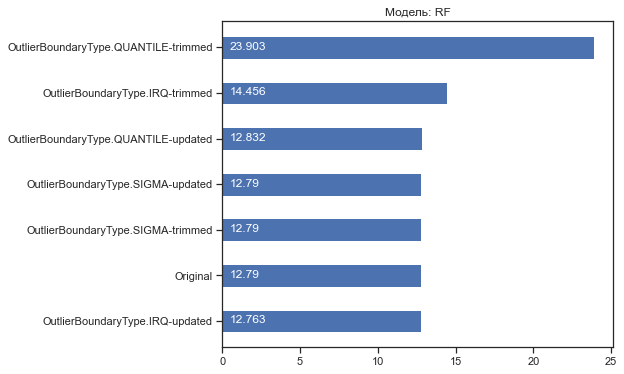

In [26]:
# Построим графики метрик качества модели
for model in clas_models_dict:
    logger.plot('Модель: ' + model, model, figsize=(7, 6))